# K-Means

In [21]:
# Import libraries
import glob
import numpy as np
import PIL.Image as Image
import sklearn.cluster as cluster
import scipy.stats as stats
import matplotlib.pyplot as plt

In [22]:
# Calculates 1d Power Spectrum
def power_spectrum_1d(image):

    # Get pixel count
    pixel_count = image.shape[0]

    # Convert into fourier transform
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)
    
    return a_bins


In [23]:
# Collect all images in AIA171_Miniset_BW and represent them as numpy arrays
x = []
image_paths = glob.glob('./../../AIA171_Miniset_BW/**/*.jpg', recursive = True)
for image_path in image_paths:
    image = np.array(Image.open(image_path).convert('L'))
    image = image.astype(float) / 255
    x.append(power_spectrum_1d(image))
x = np.array(x)   

c:\Users\starf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


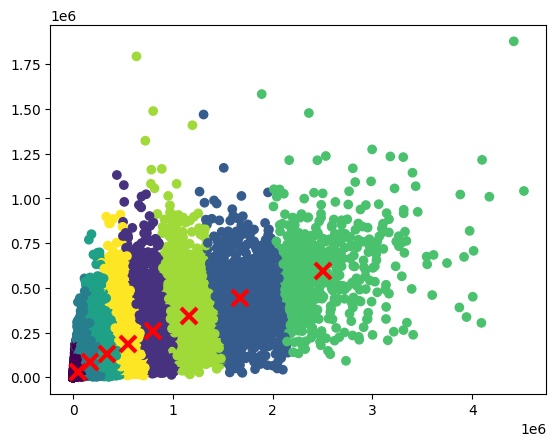

In [31]:
# Perform K-Means
clust = cluster.KMeans().fit(x)
plt.scatter(x[:,0], x[:,1], c = clust.predict(x))
plt.plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3)
plt.show()
